### Conformalized quantile regression(CQR)

The link to the original paper
http://papers.neurips.cc/paper/8613-conformalized-quantile-regression.pdf

We use the package in the following link for experiment

https://github.com/yromano/cqr

Note that we use this CQR for median, calibration, and 90% interval only. 

We use the model under the random forest specification with symmetric interval and recommended hyperparameter from the package example

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from cqr import helper
from scipy.interpolate import interp1d
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc
from scipy import stats

%matplotlib inline

### load data

In [2]:
dt=np.load('energy_dt/energydt.npy')

# the full design matrix
x=dt[:,:-1]
y=dt[:,-1]


# compute input dimensions
in_shape = x.shape[1]

stats.describe(y)

DescribeResult(nobs=1441, minmax=(-2.2052207299156037, 5.333679641267546), mean=-0.0032660240952695646, variance=0.985302073606261, skewness=0.5683701905151197, kurtosis=1.3028270149021273)

### hyperparameter

In [3]:
#########################################################
# Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py)
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = x.shape[1]


# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10


# define the QRF's parameters 
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

### Ten Replications to evaluate the hard metrics

In [4]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [5]:
#initialize the metric
cqrcal=[]
cqrcalshp=[] #empirical coverage
cqrwidth=[] #empirical width
cqr90=[] #90 interval coverage
cqrmae=[]

In [6]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)

    # compute input dimensions
    n_train=len(train_x)
    n_test=len(test_x)
    in_shape = train_x.shape[1]

    # display basic information
    print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
          (train_x.shape[0], train_x.shape[1], test_x.shape[0], test_x.shape[1]))



    # divide the data into proper training set and calibration set
    idx = np.random.permutation(n_train)
    n_half = int(np.floor(n_train/2))
    idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

    def cqr_lu(level):

        # desired quanitile levels
        quantiles = [0.5-level/2, 0.5+level/2]
        # target quantile levels
        quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

        # desired miscoverage error
        alpha = 1-level


        # define QRF model
        quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                               fit_params=None,
                                                               quantiles=quantiles_forest,
                                                               params=params_qforest)

        # define the CQR object
        nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

        # run CQR procedure
        y_lower, y_upper = helper.run_icp(nc, train_x, train_y, test_x, idx_train, idx_cal, alpha)

        return y_lower,y_upper


    
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness

    
    


    cqrc=[]

    for i in per:
        lquantile,rquantile=cqr_lu(i)
        cqrc.append(np.mean((test_y<rquantile)*(test_y>lquantile)))

    cqrcal.append(cqrc)
    
    
    cqrc1=[]    
    cqrwid=[]
    for i in pershp:
        lquantile,rquantile=cqr_lu(i)
        cqrc1.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))
        cqrwid.append(np.median(rquantile-lquantile))
        
        
    cqrcalshp.append(np.array(cqrc1))    
    cqrwidth.append(np.array(cqrwid))
    
    #ninty
    lquantile90,rquantile90=cqr_lu(0.9)
    cqr90.append(np.mean((test_y<rquantile90)*(test_y>lquantile90)))
    
    
    #mae    
    lquantile50,rquantile50=cqr_lu(0.02)
    cqrmae.append(np.abs((lquantile50+rquantile50)/2.-test_y.ravel()).mean())



Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)
Dimensions: train set (n=865, p=7) ; test set (n=576, p=7)


In [7]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(cqr90)
musd(cqrmae)

0.9100694444444445 0.011138204814128772
0.5519227293263975 0.01688449200710158


In [8]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

cqrcalplot=calcompu(cqrcal)

0.022329985119047602 0.009375396037061166


In [9]:
cqrcalplot

array([0.01944444, 0.17881944, 0.30920139, 0.44357639, 0.58611111,
       0.71857639, 0.8578125 , 0.97934028])

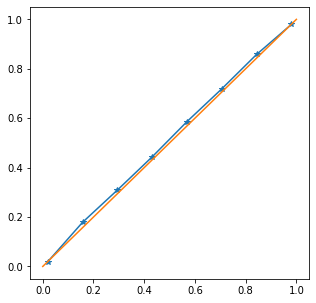

In [10]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,cqrcalplot,'-*')

plt.plot([0,1],[0,1])

In [15]:
def shpplt(cal,width): #median interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)

    

In [19]:
cqrempcal,cqrempwid=shpplt(cqrcalshp,cqrwidth)

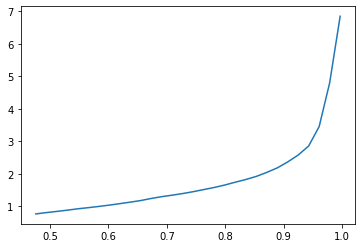

In [18]:
plt.plot(cqrempcal,cqrempwid)